<a href="https://colab.research.google.com/github/KazGet/Summer_prac/blob/main/Summer_practies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost
from catboost import CatBoostRegressor, CatBoostClassifier, Pool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from google.colab import drive; drive.mount('/content/drive')
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, RocCurveDisplay, roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFE, RFECV, SelectKBest, f_classif
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import Lasso, LassoCV
from sklearn.pipeline import Pipeline

In [150]:
file = "/content/main.xlsx"
df = pd.read_excel(file, sheet_name=1)
df=df.drop([0,"Complete/CENSORED (Данные завершены/ вышел из тестирования)",
            "HisDiseasNumb", "date prior MI (Дата предыдущего инфаркта)",
            "date CABG", "date prior PCI", "Plaque texture", "Plaque echogenicity", "Hb",
            "Troponine", "BNP",	"NTproBNP","hsCRP", "ALT", "AST", "GGT", "bilirubin", "Therapy anti diabetic drugs",
            "Therapy: digitalis", "Therapy other (specify)", "LM (%)", "LAD (%)", "RCA (%)",
            "LCx (%)", "max%sten",	"FFR, LAD",	"FFR, RCA",	"FFA, Cx","iFR, LAD","iFR, RCA","iFR, Cx", "EQL-5", "GLS RV stress", "Angiography", "6-min test, metres", "HbA1"], axis=1)
df=df.drop("Phenotype angio: 0 - анат-, гемо-, 1- анат-, гемо + (по ФРК, где есть), 2 - анат+, гемо -, 3 - анат+, гемо +", axis=1)
out_the_door=[
              'Minutes Exercise', 'Sat O2 rest', 'HR rest', 'SBP rest', 'DBP rest', 'MM rest', 'LVEDV rest', 'LVESV  rest', 'WMSI  rest', 'SV rest', 'LAD at rest', 'B-lines at rest', 'GLS rest',
              'LA vol rest', 'RA vol rest', 'E rest', 'A rest', 'DTE rest', "e' rest", "a' rest", "s' rest", 'TAPSE rest', 'S RV rest', 'MR rest', 'TR vel rest',
              'RVSP rest', 'GLS RV rest', 'Diast dysfunc rest', 'HR stress', 'SBP stress', 'DBP stress', 'LVEDV stress', 'LVESV stress', 'WMSI stress', 'SV stress',
              'LAD stress', 'B-lines stress', 'GLS stress-', 'LA vol  stress', 'RA vol stress', 'E  stress', 'A  stress', 'DTE stress', "e'  stress",
              "a'  stress", "s'  stress", 'TAPSE  stress', 'S RV  stress', 'MR  stress', 'TR vel  stress', 'RVSP  stress', 'Diast dysfunc  stress']
df=df.drop(out_the_door, axis=1)

df.drop(['Date of stress', 'Date Angiography', 'Data of birth', 'Last FU, Date (Дата последнего контрольного осмотра)'], axis=1, inplace=True)
df['LBBB (Блокада левой ножки пучка Гиса)'] = df['LBBB (Блокада левой ножки пучка Гиса)'].replace('RBBB', 0)
rbbb_mask = df['LBBB (Блокада левой ножки пучка Гиса)'] == 0
df['RBBB'] = rbbb_mask.astype(int)

categorical_features = ["ECG Rhythm (Ритм по ЭКГ)", "Smoker", "Stress Type", "Reason for Referral",
                        "Reason of Stress Stop","Peak ECG"]
df[categorical_features] = df[categorical_features].fillna("NaN").astype(str)

X = df.drop('All sten range (Каранарография)', axis=1)
y = df['All sten range (Каранарография)']

# encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
# X[categorical_features] = encoder.fit_transform(X[categorical_features])
# X.columns = X.columns.astype(str)
# X.columns = X.columns.str.replace(r'[\[\]<>]', '', regex=True)

mask = df['All sten range (Каранарография)'].isin([0, 1])
X = X[mask]
y = y[mask]

/tmp/ipython-input-150-3072846023.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['LBBB (Блокада левой ножки пучка Гиса)'] = df['LBBB (Блокада левой ножки пучка Гиса)'].replace('RBBB', 0)


In [ ]:
# @title Регрессор
X_train, X_test, y_train, y_test = train_test_split(
    X.drop(indexes_for_test), y.drop(indexes_for_test),
    test_size=0.2,
    random_state=42,
    shuffle=True
)

modelreg = CatBoostRegressor(
    iterations=500,
    learning_rate=0.01,
    depth=4,
    cat_features=categorical_features,
    eval_metric='RMSE',
    l2_leaf_reg=1,
    verbose=100
)

modelreg.fit(X_train, y_train)

# for j,i in zip(list(map(round, pred)), y_test):
#   if j!=int(i):
#     print(1)

# feature_importance = model.get_feature_importance()
# for name, score in zip(X_train.columns, feature_importance):
#     print(f"{name}: {round(score, 3)}")


# plt.barh(X_train.columns, feature_importance)
# plt.title('Важность признаков')
# plt.show()

from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error


y_pred = modelreg.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")
print(f"R²: {r2}")

# scores = cross_val_score(modelreg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
# rmse_scores = (-scores)**0.5
# print(f"Средний RMSE на кросс-валидации: {rmse_scores.mean()}")

0:	learn: 0.4734985	total: 79.9ms	remaining: 39.8s
100:	learn: 0.2962319	total: 2.54s	remaining: 10s
200:	learn: 0.2385774	total: 4.78s	remaining: 7.11s
300:	learn: 0.2140942	total: 6.56s	remaining: 4.34s
400:	learn: 0.1972232	total: 8.3s	remaining: 2.05s
499:	learn: 0.1828592	total: 10.5s	remaining: 0us


In [133]:
X_boost_for_cat = X[['LPHD_Ch', 'Reason for Referral', 'ESC Pre-test Probability', "slow flow", 'Body surface area', 'FFR range']]

In [ ]:
# @title CatBoostClassifier
X_train, X_test, y_train, y_test = train_test_split(
    X_boost_for_cat, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)
train_pool = Pool(X_train, label=y_train)
test_pool = Pool(X_test, label=y_test)

model = CatBoostClassifier(depth = 3, iterations=100, l2_leaf_reg = 1, learning_rate = 0.01, verbose=20, bagging_temperature=0)
model.fit(train_pool)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_pred_proba))

y_pred_proba = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Вывод важности признаков
for i in range(len(X_boost_for_cat.columns)):
    print(f"{X_boost_for_cat.columns[indices[i]]}: {importances[indices[i]]:.4f}")

In [8]:
# @title Удаление полупустых признаков и заполнение медианой
missing_percent = df.isnull().mean()
cols_to_drop = missing_percent[missing_percent > 0.3].index
df_dropped = df.drop(cols_to_drop, axis=1)

X_dropped = df_dropped.drop('All sten range (Каранарография)', axis=1)

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_dropped[categorical_features] = encoder.fit_transform(X_dropped[categorical_features])
X_dropped = X_dropped[mask]

imputer = SimpleImputer(strategy='median')
X_filled = imputer.fit_transform(X_dropped)
X_filled_data = pd.DataFrame(X_filled, columns=X_dropped.columns)

In [9]:
# @title Заполнение методом KNNImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(X.select_dtypes(include=[np.number]))

imputer = KNNImputer(n_neighbors=5)
df_imputed_scaled = imputer.fit_transform(df_scaled)
df_KNN = scaler.inverse_transform(df_imputed_scaled)
df_final = pd.DataFrame(df_KNN, columns=X.columns)

In [23]:
# @title Заполнение пропусков методом Iterative Imputer
imputer = IterativeImputer(max_iter=20, random_state=0)
df_imputed = imputer.fit_transform(X)
df_MICE = pd.DataFrame(df_imputed, columns=X.columns)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [11]:
# @title Заполнение пропусков методом MissForest
!pip install missforest
from missforest import MissForest

mf = MissForest(
    clf=RandomForestClassifier(n_jobs=-1),
    rgr=RandomForestRegressor(n_jobs=-1),
    categorical=categorical_features,
)
df_miss_forest = mf.fit_transform(X)

/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [08:58<00:00, 107.60s/it]
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process

X_med: Компоненты, объясняющие 95% дисперсии = 56
df_KNN: Компоненты, объясняющие 95% дисперсии = 60
df_MICE: Компоненты, объясняющие 95% дисперсии = 58
df_MissForest: Компоненты, объясняющие 95% дисперсии = 60


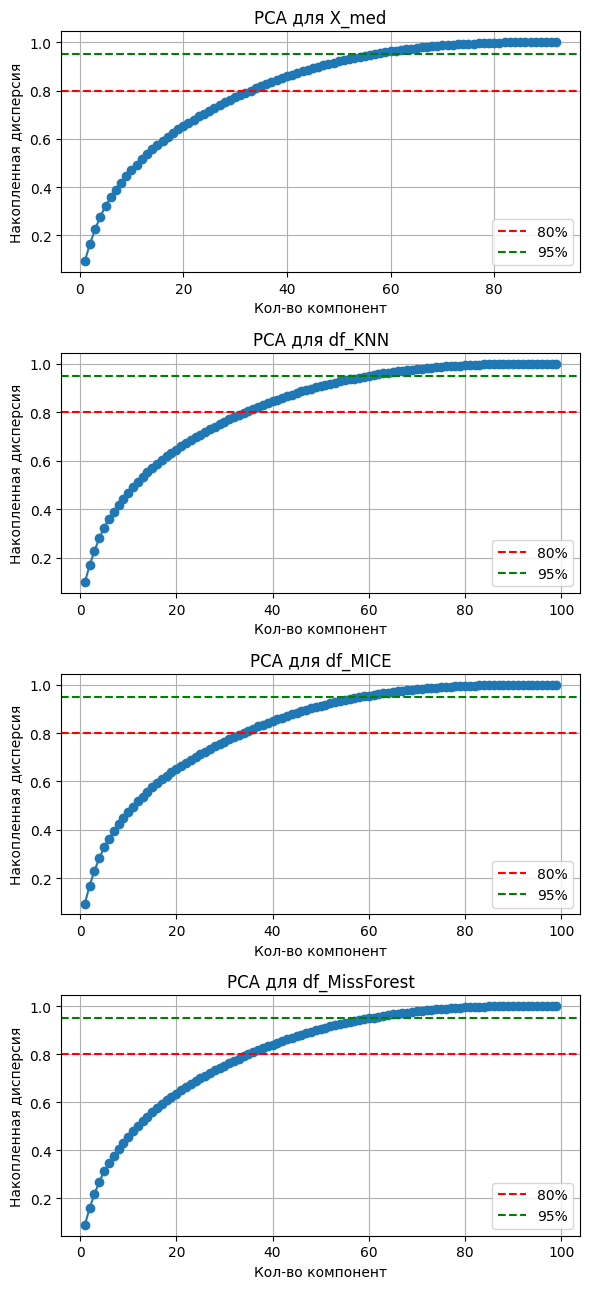

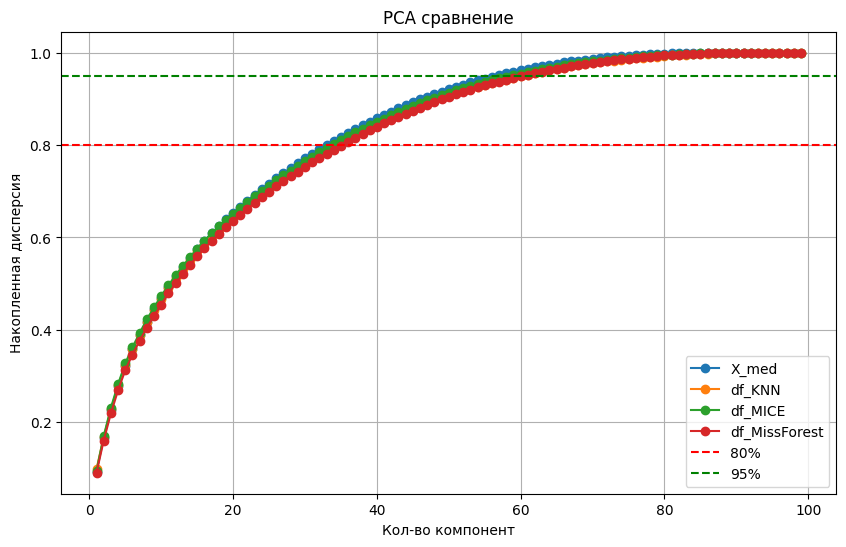

In [166]:
# @title PCA
fig, axes = plt.subplots(4, 1, figsize=(6, 13))

datasets = [
    ("X_med", X_filled_data),
    ("df_KNN", df_final),
    ("df_MICE", df_MICE),
    ("df_MissForest", df_miss_forest)
]

for ax, (name, data) in zip(axes, datasets):
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    ax.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
    ax.axhline(0.8, color='r', linestyle='--', label='80%')
    ax.axhline(0.95, color='g', linestyle='--', label='95%')
    ax.set_xlabel('Кол-во компонент')
    ax.set_ylabel('Накопленная дисперсия')
    ax.set_title(f'PCA для {name}')
    ax.legend()
    ax.grid()

    n_components = len(list(filter(lambda x: x <= 0.95, explained_variance)))
    print(f"{name}: Компоненты, объясняющие 95% дисперсии = {n_components}")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

for name, data in datasets:
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', label=name)

plt.axhline(0.8, color='r', linestyle='--', label='80%')
plt.axhline(0.95, color='g', linestyle='--', label='95%')
plt.xlabel('Кол-во компонент')
plt.ylabel('Накопленная дисперсия')
plt.title('PCA сравнение')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# @title Отбор признаков по матрице весов PCA
X_numeric = X_filled_data.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

loadings_df = pd.DataFrame(
    data=pca.components_,
    columns=X_numeric.columns,
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)
def get_most_important_features(component, loadings_df, n_features=1):
    pc_loadings = loadings_df.loc[component]
    most_important = pc_loadings.abs().sort_values(ascending=False).head(n_features)
    return loadings_df.loc[component, most_important.index]
    # return loadings_df.loc[component]

new_X = []
for i in range(1, 41):
  new_X.append(get_most_important_features(f'PC{i}', loadings_df))
  # print(get_most_important_features(f'PC{i}', loadings_df, n_features=1))

print(new_X)
# # Визуализируем нагрузки для первых 10 компонент
# plt.figure(figsize=(15, 8))
# sns.heatmap(loadings_df.head(10), cmap='vlag', annot=False) # annot=True, если признаков не слишком много
# plt.title('Тепловая карта нагрузок PCA (первые 10 компонент)')
# plt.show()

[ABCDE score+ECG+angina    0.272474
Name: PC1, dtype: float64, LVESVi at rest    0.287928
Name: PC2, dtype: float64, H2FPEF 2018 Score    0.323298
Name: PC3, dtype: float64, Weight    0.301293
Name: PC4, dtype: float64, LV contractile reserve    0.251716
Name: PC5, dtype: float64, N_Vessel sign    0.257086
Name: PC6, dtype: float64, Delta EF >=5 - 0, <5 - 1    0.278113
Name: PC7, dtype: float64, GLS delta    0.381844
Name: PC8, dtype: float64, AF (Фибрилляция предсердий)    0.314085
Name: PC9, dtype: float64, Creatinine clearance    0.268772
Name: PC10, dtype: float64, ECG range    0.272414
Name: PC11, dtype: float64, Creatinine clearance    0.317332
Name: PC12, dtype: float64, LBBB (Блокада левой ножки пучка Гиса)    0.303257
Name: PC13, dtype: float64, LAVI stress    0.240291
Name: PC14, dtype: float64, Therapy: ACE-I    0.322972
Name: PC15, dtype: float64, E/A stress    0.329131
Name: PC16, dtype: float64, Prior MI ( Перенесённый инфаркт миокарда)    0.28578
Name: PC17, dtype: float

In [25]:
# @title Рекурсивное исключение признаков (Recursive Feature Elimination, RFE): Модель обучается на всех признаках, затем самый неважный удаляется, и процесс повторяется.
select_num = 12
selector_med = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_med.fit(X_filled, y)
selected_features_med = X_dropped.columns[selector_med.get_support()]
print("Отобранные признаки для данных, заполенными медианой: ")
print(selected_features_med.tolist())

selector_KNN = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_KNN.fit(df_KNN, y)
selected_features_KNN = X.columns[selector_KNN.get_support()]
print(f"Отобранные признаки для данных, заполенными методом ближайших соседей: ")
print(selected_features_KNN.tolist())

selector_MICE = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_MICE.fit(df_MICE, y)
selected_features_MICE = X.columns[selector_MICE.get_support()]
print(f"Отобранные признаки для данных, заполенными методом итеративного заполнения: ")
print(selected_features_MICE.tolist())

selector_MissF = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_MissF.fit(df_miss_forest, y)
selected_features_MissF = X.columns[selector_MissF.get_support()]
print(f"Отобранные признаки для данных, заполенными методом MissForest: ")
print(selected_features_MissF.tolist())

print("\nПересечение всех признаков: ")
print(set(selected_features_med) & set(selected_features_KNN) & set(selected_features_MICE) & set(selected_features_MissF))

Отобранные признаки для данных, заполенными медианой: 
['Age', 'Height', 'Body surface area', 'Peripheral artery disease (Заболевание периферических артерий)', 'LPHD_Ch', 'Type Angiography', 'N.vessels', 'N_Vessel sign', 'LAD range', 'Reason for Referral', 'IMM rest', 'HRR']
Отобранные признаки для данных, заполенными методом ближайших соседей: 
['Body surface area', 'LPHD_Ch', 'Trigliceride', 'Glukosa', 'N.vessels', 'N_Vessel sign', 'slow flow', 'LAD range', 'Reason for Referral', 'ESC Pre-test Probability', 'IMM rest', 'CFVR']
Отобранные признаки для данных, заполенными методом итеративного заполнения: 
['Age', 'LPHD_Ch', 'Glukosa', 'Type Angiography', 'N.vessels', 'N_Vessel sign', 'slow flow', 'LAD range', 'Reason for Referral', 'ESC Pre-test Probability', 'HRR', 'RAI stress']
Отобранные признаки для данных, заполенными методом MissForest: 
['Age', 'Height', 'Glukosa', 'Therapy: beta-blocker', 'Therapy: nitrate', 'Therapy: statin', 'Type Angiography', 'GLS reserve', "E/e' stress", '

In [26]:
print("\nПересечение всех признаков: ")
print(set(selected_features_med) & set(selected_features_KNN) & set(selected_features_MICE))


Пересечение всех признаков: 
{'LAD range', 'LPHD_Ch', 'N_Vessel sign', 'Reason for Referral', 'N.vessels'}


In [19]:
# @title RFECV —  RFE с автоматическим выбором числа признаков через кросс-валидацию
df_test = df_MICE
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
selector = RFECV(estimator=RandomForestClassifier(), step=1, cv=cv, scoring='accuracy', n_jobs=-1)
selector.fit(df_test, y)
selected_features = df_test.columns[selector.get_support()]
print("Оптимальное число признаков:", selector.n_features_)
print("Отобранные признаки:", selected_features.tolist())

Оптимальное число признаков: 68
Отобранные признаки: ['Age', 'Sex', 'Height', 'Weight', 'Body mass index', 'Body surface area', 'Smoker', 'COPD (хроническая обструктивная болезнь легких)', 'PCI past Прошлое стентирование (черезкожное вмешательство)', 'Peripheral artery disease (Заболевание периферических артерий)', 'Carotid artery disease (Заболевание сонной артерии)', 'Cholesterol', 'LPLD_Ch', 'LPHD_Ch', 'Trigliceride', 'Creatinine', 'Creatinine clearance', 'Glukosa', 'Therapy: beta-blocker', 'Therapy: statin', 'Therapy: other antiplatelet agent', 'Type Angiography', 'N.vessels', 'slow flow', 'FFR range', 'Reason for Referral', 'ESC Pre-test Probability', 'NYHA Class', 'ESC 2019 HFpEF Score', 'H2FPEF 2018 Score', 'Stress Time', 'Reason of Stress Stop', 'Peak ECG', 'IMM rest', 'LVEDVi at rest', 'LVESVi at rest', 'LVEF% at rest', 'SI rest', 'LV force rest', 'LAVI rest', 'RAVI rest', 'E/A rest', "E/e' rest", 'HRR', 'LVEDVi stress', 'LVESVi stress', 'LVEF% stress', 'delta EF', 'SI stress'

In [27]:
# @title Отбор признаков методом ANOVA: оценка стат. связи между каждым признаком и целевой переменной
selector1 = SelectKBest(score_func=f_classif, k=select_num)
X_med = selector1.fit_transform(X_filled, y)
selector2 = SelectKBest(score_func=f_classif, k=select_num)
X_KNN = selector2.fit_transform(df_KNN, y)
selector3 = SelectKBest(score_func=f_classif, k=select_num)
X_MICE = selector3.fit_transform(df_MICE, y)
selector4 = SelectKBest(score_func=f_classif, k=select_num)
X_MF = selector4.fit_transform(df_miss_forest, y)

scores1 = selector1.scores_
p_values1 = selector1.pvalues_
scores2 = selector2.scores_
p_values2 = selector2.pvalues_
scores3 = selector3.scores_
p_values3 = selector3.pvalues_
scores4 = selector4.scores_
p_values4 = selector4.pvalues_


# for i, col in enumerate(X.columns):
#     print(f"Признак '{col}': F-score = {scores[i]:.2f}, p-value = {p_values[i]:.4f}")

selected_features1 = X_dropped.columns[selector1.get_support()]
print(f"\nОтобранные признаки с данными с медианой:\n {list(selected_features1)}")

selected_features2 = X.columns[selector2.get_support()]
print(f"\nОтобранные признаки с данными KNN:\n {list(selected_features2)}")

selected_features3 = X.columns[selector3.get_support()]
print(f"\nОтобранные признаки с данными MICE:\n {list(selected_features3)}")

selected_features4 = X.columns[selector4.get_support()]
print(f"\nОтобранные признаки с данными MF:\n {list(selected_features4)}")

print("\nПересечение всех результатов:")
print(set(selected_features1) & set(selected_features2) & set(selected_features3))


Отобранные признаки с данными с медианой:
 ['Sex', 'Prior MI ( Перенесённый инфаркт миокарда)', 'PCI past Прошлое стентирование (черезкожное вмешательство)', 'Peripheral artery disease (Заболевание периферических артерий)', 'Carotid artery disease (Заболевание сонной артерии)', 'Therapy: beta-blocker', 'Therapy: statin', 'Type Angiography', 'N.vessels', 'N_Vessel sign', 'slow flow', 'LAD range']

Отобранные признаки с данными KNN:
 ['Sex', 'PCI past Прошлое стентирование (черезкожное вмешательство)', 'Peripheral artery disease (Заболевание периферических артерий)', 'Carotid artery disease (Заболевание сонной артерии)', 'LPHD_Ch', 'Type Angiography', 'N.vessels', 'N_Vessel sign', 'slow flow', 'LAD range', 'FFR range', 'ESC Pre-test Probability']

Отобранные признаки с данными MICE:
 ['Sex', 'Prior MI ( Перенесённый инфаркт миокарда)', 'PCI past Прошлое стентирование (черезкожное вмешательство)', 'Peripheral artery disease (Заболевание периферических артерий)', 'Carotid artery disease (

In [28]:
# @title Отбор по LassoCV
def run_lasso_selection(X_source, y, name, feature_names):
    # Стандартизация + подбор alpha через кросс-валидацию
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso_cv', LassoCV(cv=5, max_iter=10000))
    ])

    pipeline.fit(X_source, y)
    best_alpha = pipeline.named_steps['lasso_cv'].alpha_

    print(f"\n{name}: наилучшее значение alpha = {best_alpha:.4f}")

    # Финальная модель с выбранным alpha
    lasso = Lasso(alpha=best_alpha, max_iter=10000)
    X_scaled = StandardScaler().fit_transform(X_source)
    lasso.fit(X_scaled, y)

    # Отбор ненулевых коэффициентов
    non_zero_coefs = np.where(lasso.coef_ != 0)[0]
    selected = feature_names[non_zero_coefs]

    print(f"\nВыбранные признаки для {name}:\n", selected.tolist())
    return set(selected)

# Прогоним для всех способов заполнения
features_median = run_lasso_selection(X_filled, y, "Median", X_dropped.columns)
features_knn    = run_lasso_selection(df_KNN, y, "KNN", X.columns)
features_mice   = run_lasso_selection(df_MICE, y, "MICE", X.columns)
features_mf     = run_lasso_selection(df_miss_forest, y, "MissForest", X.columns)

# Пересечение всех
print("\nПересечение всех признаков:")
intersection = features_median & features_knn & features_mice & features_mf
print(intersection)



Median: наилучшее значение alpha = 0.0099

Выбранные признаки для Median:
 ['Sex', 'Obesity (Ожирение)', 'COPD (хроническая обструктивная болезнь легких)', 'Prior MI ( Перенесённый инфаркт миокарда)', 'CABG Аортокоронарное шунтирование', 'PCI past Прошлое стентирование (черезкожное вмешательство)', 'Peripheral artery disease (Заболевание периферических артерий)', 'Therapy: beta-blocker', 'Therapy: nitrate', 'Therapy: statin', 'Therapy: diuretic', 'Therapy: aspirin', 'Therapy: anticoagulant', 'Type Angiography', 'N.vessels', 'N_Vessel sign', 'slow flow', 'LAD range', 'Гемодин. 1, не значим. 0', 'Peak ECG', 'Depression of the ST-1 >2 mm, 2-1-2 mm, 3-without depression', 'LVEF% at rest', 'E/A rest', 'SI stress', 'LV force stress', 'GLS reserve', 'E/A stress', 'Diast dysfunc  range', 'D WMSI', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма', 'ABCDE score+ECG+a

In [29]:
# @title Объединение методов

#Удалим признаки с >50% пропусков
missing_percent = df.isnull().mean()
cols_to_drop = missing_percent[missing_percent > 0.2].index
df_dropped = df.drop(cols_to_drop, axis=1)
X_d = df_dropped.drop('All sten range (Каранарография)', axis=1)
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_d[categorical_features] = encoder.fit_transform(X_d[categorical_features])
X_d = X_d[mask]

#Используем IterativeImputer для заполнения оставшихся признаков
mf = MissForest(
    clf=RandomForestClassifier(n_jobs=-1),
    rgr=RandomForestRegressor(n_jobs=-1),
    categorical=categorical_features,
)
df_after_MF = mf.fit_transform(X_d)

imputer = IterativeImputer(max_iter=20, random_state=0)
df_after_MICE = imputer.fit_transform(X_d)
df_after_MICE = pd.DataFrame(df_after_MICE, columns=X_d.columns)

#Масшитабируем
X_numeric = df_after_MICE.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

X_numeric_ = df_after_MF.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled_ = scaler.fit_transform(X_numeric_)

#Сделаем отбор по методу RFE
selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector.fit(X_scaled, y)
selected_features_MICE = X_d.columns[selector.get_support()]
print("Отобранные признаки методом RFE+MICE: ")
print(selected_features_MICE.tolist())

selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector.fit(X_scaled_, y)
selected_features_MF = X_d.columns[selector.get_support()]
print("Отобранные признаки методом RFE+MF: ")
print(selected_features_MF.tolist())

#Сделаем отбор методом ANOVA
selector_ANOVA = SelectKBest(score_func=f_classif, k=select_num)
X_anova = selector_ANOVA.fit_transform(X_scaled, y)

selector_ANOVA_ = SelectKBest(score_func=f_classif, k=select_num)
X_anova_ = selector_ANOVA_.fit_transform(X_scaled_, y)

scores = selector_ANOVA.scores_
p_values = selector_ANOVA.pvalues_

scores = selector_ANOVA_.scores_
p_values = selector_ANOVA_.pvalues_

selected_featuresMICE = X_d.columns[selector_ANOVA.get_support()]
print(f"\nОтобранные признаки методом ANOVA:\n {list(selected_featuresMICE)}")

print("Общие признаки в RFE и ANOVA:", set(selected_features_MICE) & set(selected_featuresMICE))

selected_featuresMF = X_d.columns[selector_ANOVA_.get_support()]
print(f"\nОтобранные признаки методом ANOVA (MF):\n {list(selected_featuresMF)}")

print("Общие признаки в RFE и ANOVA:", set(selected_features_MF) & set(selected_featuresMF))

/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [06:36<00:00, 79.35s/it]
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process 

Отобранные признаки методом RFE+MICE: 
['Age', 'Height', 'Peripheral artery disease (Заболевание периферических артерий)', 'LPHD_Ch', 'Creatinine', 'Type Angiography', 'N.vessels', 'N_Vessel sign', 'LAD range', 'Reason for Referral', 'HRR', 'LAVI stress']
Отобранные признаки методом RFE+MF: 
['Body surface area', 'LPHD_Ch', 'Creatinine', 'Creatinine clearance', 'Glukosa', 'Therapy: calcium antagonist', 'Therapy: statin', 'Type Angiography', 'E/A rest', 'Delta EF >=5 - 0, <5 - 1', 'WMSI range', 'ABCDE score+ECG+angina']

Отобранные признаки методом ANOVA:
 ['Sex', 'Prior MI ( Перенесённый инфаркт миокарда)', 'PCI past Прошлое стентирование (черезкожное вмешательство)', 'Peripheral artery disease (Заболевание периферических артерий)', 'Carotid artery disease (Заболевание сонной артерии)', 'LPHD_Ch', 'Therapy: beta-blocker', 'Therapy: statin', 'Type Angiography', 'N.vessels', 'N_Vessel sign', 'LAD range']
Общие признаки в RFE и ANOVA: {'Type Angiography', 'LAD range', 'LPHD_Ch', 'Peripher

In [151]:
# @title XGBoost
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[categorical_features] = encoder.fit_transform(X[categorical_features])
X.columns = X.columns.astype(str)
X.columns = X.columns.str.replace(r'[\[\]<>]', '', regex=True)

Accuracy: 0.8607594936708861
Recall: 0.9411764705882353

Classification report:
               precision    recall  f1-score   support

         0.0       0.87      0.71      0.78        28
         1.0       0.86      0.94      0.90        51

    accuracy                           0.86        79
   macro avg       0.86      0.83      0.84        79
weighted avg       0.86      0.86      0.86        79


Confusion matrix:
 [[20  8]
 [ 3 48]]
ROC AUC (Train): 0.8780357142857143
ROC AUC: 0.9233193277310924


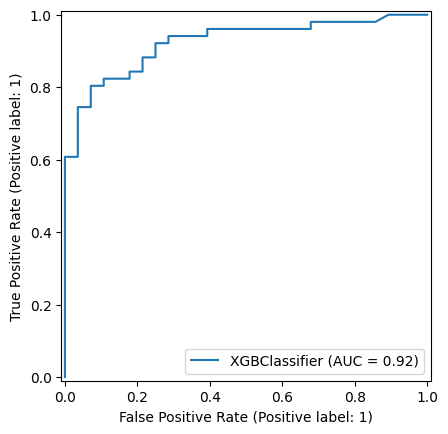

<Figure size 2000x1200 with 0 Axes>

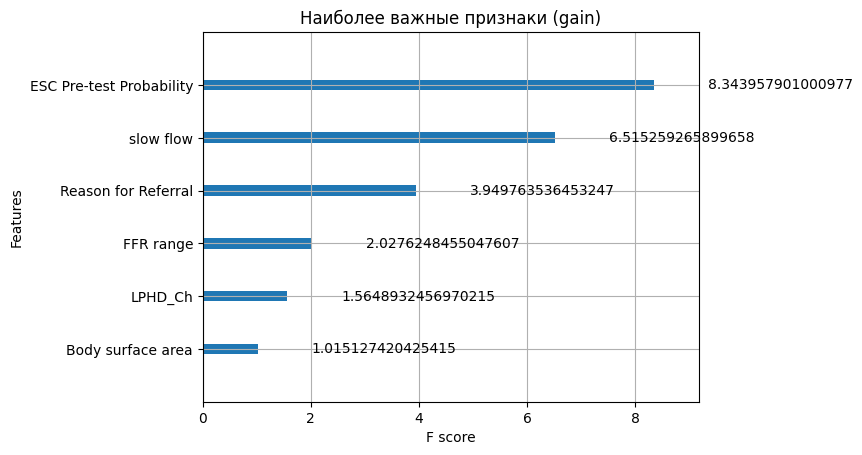

In [192]:
# Выделенные показатели для модели:
X_boost = X[['LPHD_Ch', 'Reason for Referral', 'ESC Pre-test Probability', "slow flow", 'Body surface area', 'FFR range']]

X_train, X_test, y_train, y_test = train_test_split(X_boost, y, stratify=y, random_state=42, test_size=0.2)

model = XGBClassifier(
    n_estimators=50,
    max_depth=3,
    scale_pos_weight=1,
    learning_rate=0.05,
    reg_lambda=9,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc'
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_pred_proba))

y_pred_proba = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

plt.figure(figsize=(20, 12))
plot_importance(model, max_num_features=20, importance_type='gain')
plt.title("Наиболее важные признаки (gain)")
plt.show()

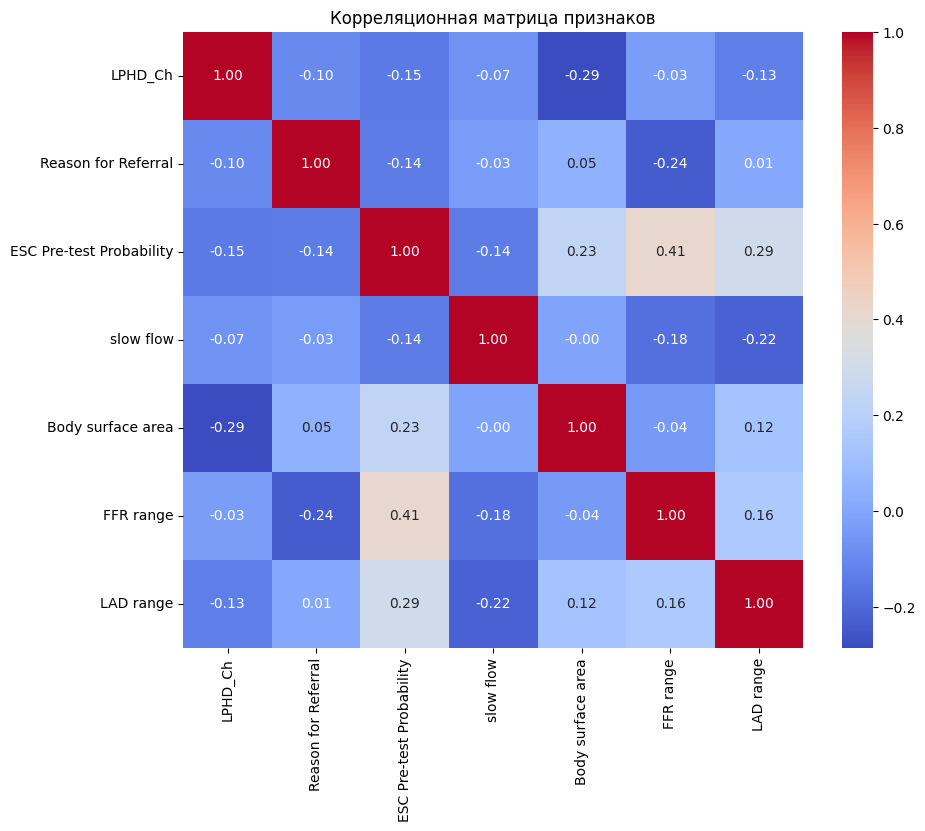

In [157]:
# @title Матрица корреляции для отобранных признаков
corr_matrix = X_boost.corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица признаков')
plt.show()

df_KNN: Компоненты, объясняющие 95% дисперсии = 5
df_MICE: Компоненты, объясняющие 95% дисперсии = 5
df_MissForest: Компоненты, объясняющие 95% дисперсии = 5


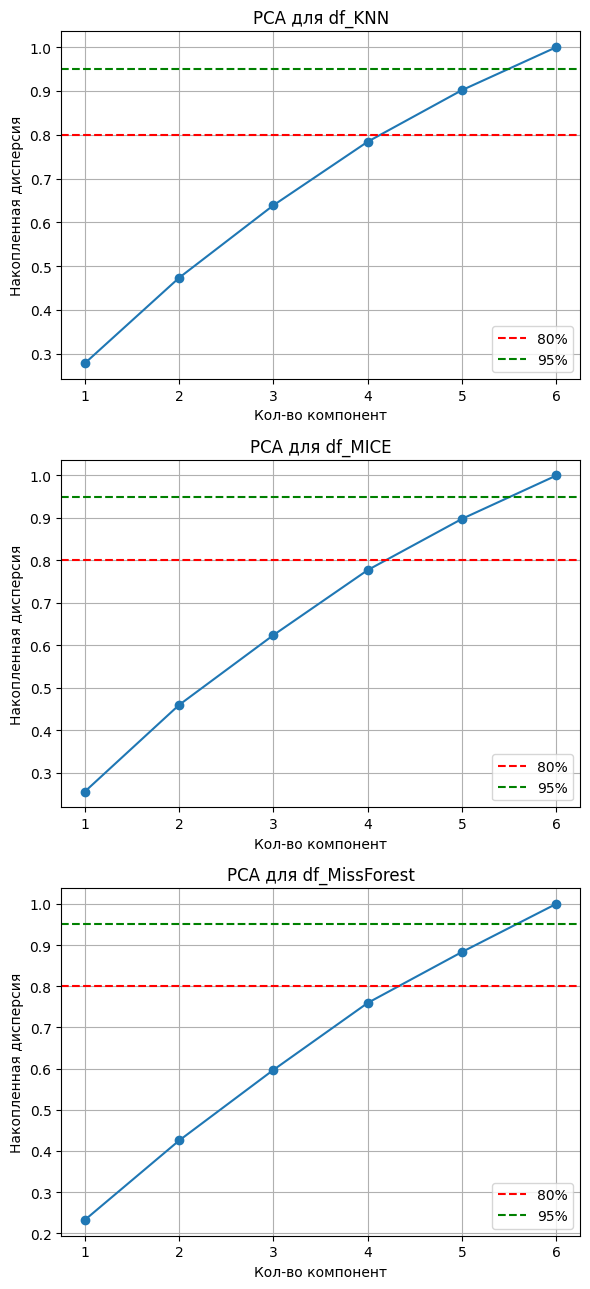

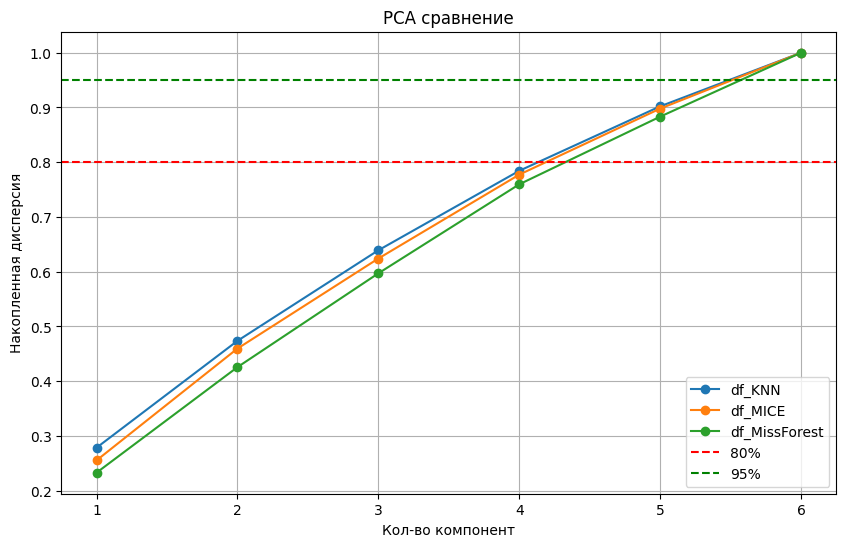

In [188]:
# @title PCA для отобранных признаков
fig, axes = plt.subplots(3, 1, figsize=(6, 13))

datasets = [
    ("df_KNN", df_final),
    ("df_MICE", df_MICE),
    ("df_MissForest", df_miss_forest)
]

for ax, (name, data) in zip(axes, datasets):
    data=data[['LPHD_Ch', 'Reason for Referral', 'ESC Pre-test Probability', "slow flow", 'Body surface area', 'FFR range']]
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    ax.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
    ax.axhline(0.8, color='r', linestyle='--', label='80%')
    ax.axhline(0.95, color='g', linestyle='--', label='95%')
    ax.set_xlabel('Кол-во компонент')
    ax.set_ylabel('Накопленная дисперсия')
    ax.set_title(f'PCA для {name}')
    ax.legend()
    ax.grid()

    n_components = len(list(filter(lambda x: x <= 0.95, explained_variance)))
    print(f"{name}: Компоненты, объясняющие 95% дисперсии = {n_components}")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

for name, data in datasets:
    data=data[['LPHD_Ch', 'Reason for Referral', 'ESC Pre-test Probability', "slow flow", 'Body surface area', 'FFR range']]
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', label=name)

plt.axhline(0.8, color='r', linestyle='--', label='80%')
plt.axhline(0.95, color='g', linestyle='--', label='95%')
plt.xlabel('Кол-во компонент')
plt.ylabel('Накопленная дисперсия')
plt.title('PCA сравнение')
plt.legend()
plt.grid()
plt.show()


ESC Pre-test Probability    0.594418
Body surface area           0.572147
LPHD_Ch                    -0.455953
FFR range                   0.280731
slow flow                  -0.161018
Reason for Referral        -0.081762
Name: PC1, dtype: float64
slow flow                   0.480523
Reason for Referral         0.472664
LPHD_Ch                    -0.466462
FFR range                  -0.403250
Body surface area           0.306638
ESC Pre-test Probability   -0.267326
Name: PC2, dtype: float64
Reason for Referral         0.743019
slow flow                  -0.665853
LPHD_Ch                     0.052700
ESC Pre-test Probability   -0.030482
FFR range                   0.022566
Body surface area          -0.018615
Name: PC3, dtype: float64
FFR range                   0.837053
slow flow                   0.369557
Reason for Referral         0.302403
Body surface area          -0.210963
ESC Pre-test Probability   -0.128463
LPHD_Ch                    -0.101559
Name: PC4, dtype: float64
LPHD_Ch 

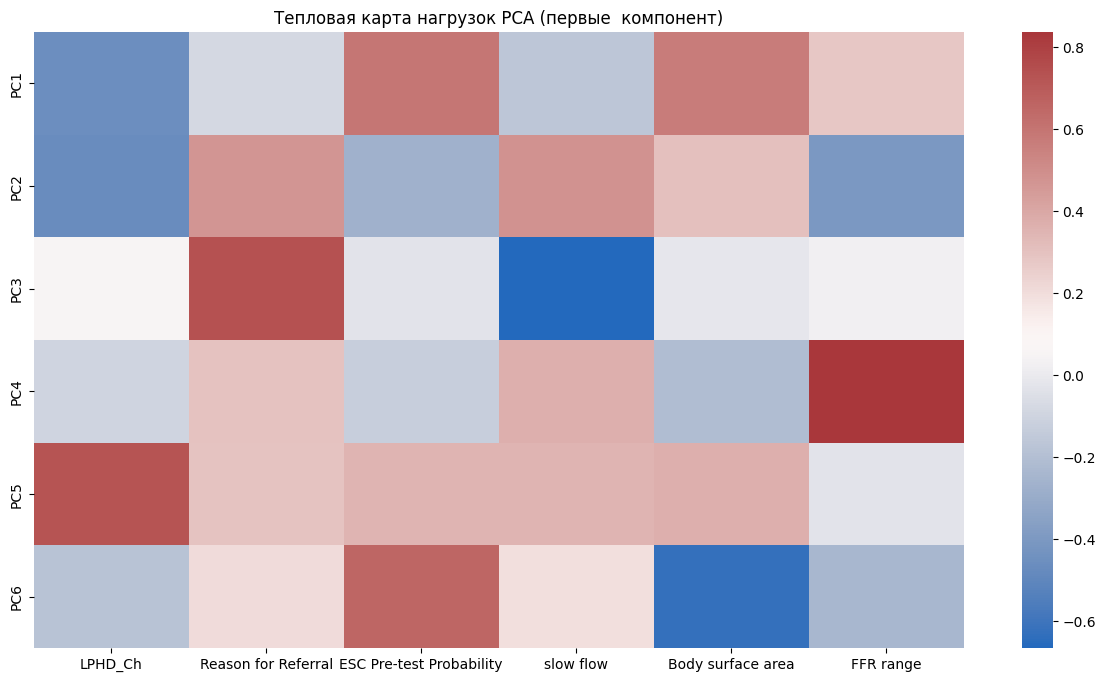

In [189]:
# @title Веса главных компонент по всем признакам
data=df_MICE[['LPHD_Ch', 'Reason for Referral', 'ESC Pre-test Probability', "slow flow", 'Body surface area', 'FFR range']]
X_numeric = data.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

loadings_df = pd.DataFrame(
    data=pca.components_,
    columns=X_numeric.columns,
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)
def get_most_important_features(component, loadings_df, n_features=10):
    pc_loadings = loadings_df.loc[component]
    most_important = pc_loadings.abs().sort_values(ascending=False).head(n_features)
    return loadings_df.loc[component, most_important.index]
    # return loadings_df.loc[component]

for i in range(1, 7):
  print(get_most_important_features(f'PC{i}', loadings_df, n_features=10))

# print(new_X)
plt.figure(figsize=(15, 8))
sns.heatmap(loadings_df.head(10), cmap='vlag', annot=False)
plt.title('Тепловая карта нагрузок PCA (первые  компонент)')
plt.show()

In [ ]:
# @title Optuna
!pip install optuna
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 20, 300),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 9.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 3.0),
        'use_label_encoder': False,
        'eval_metric': 'error'
    }

    model = XGBClassifier(**params, random_state=42)

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_boost, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    return np.mean(scores)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1500, timeout=1800)

print("🎯 Best trial:")
print("  AUC:", study.best_value)
print("  Params:", study.best_params)



best_params = study.best_params
best_params['eval_metric'] = 'error'

model = XGBClassifier(**best_params, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_pred_proba))

y_pred_proba = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()